Starting training...
Epoch 001 loss=0.500385 time=33.4s
Epoch 002 loss=0.092059 time=21.6s
Epoch 003 loss=0.024132 time=21.5s
Epoch 004 loss=0.033240 time=23.1s
Epoch 005 loss=0.027969 time=12.6s

Generating predictions on test set...
Saved alpha_test_pred100.npy with shape (1000, 1)

Evaluating on training subset...


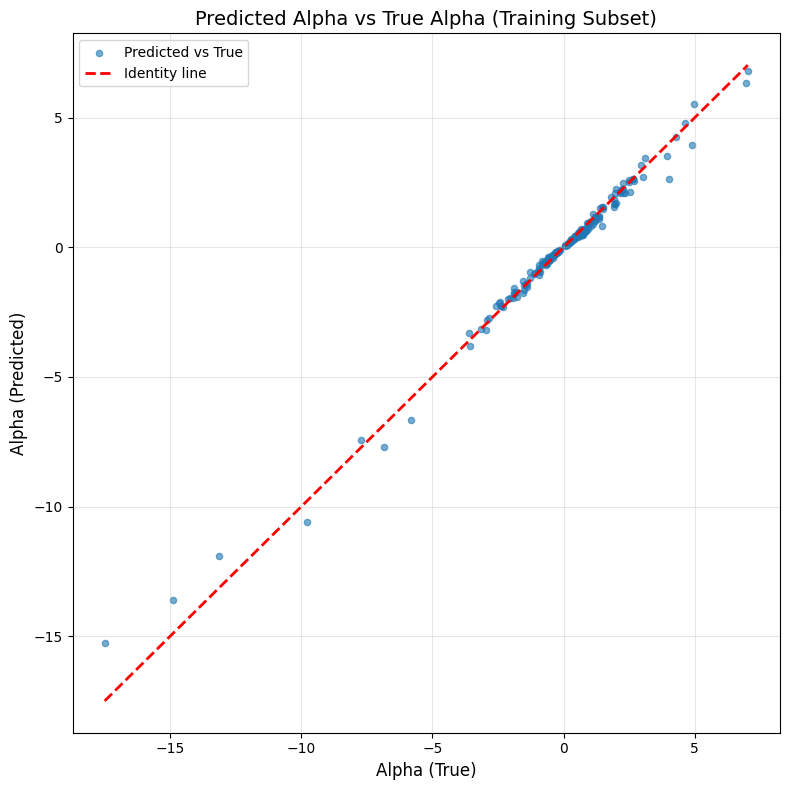


Training subset metrics:
MAE: 0.162594
RMSE: 0.300642
Correlation: 0.995127
Starting training...
Epoch 001 loss=0.496390 time=39.8s
Epoch 002 loss=0.091254 time=27.3s
Epoch 003 loss=0.046643 time=27.1s
Epoch 004 loss=0.019330 time=26.3s
Epoch 005 loss=0.013250 time=17.5s

Generating predictions on test set...
Saved alpha_test_pred75.npy with shape (1000, 1)

Evaluating on training subset...


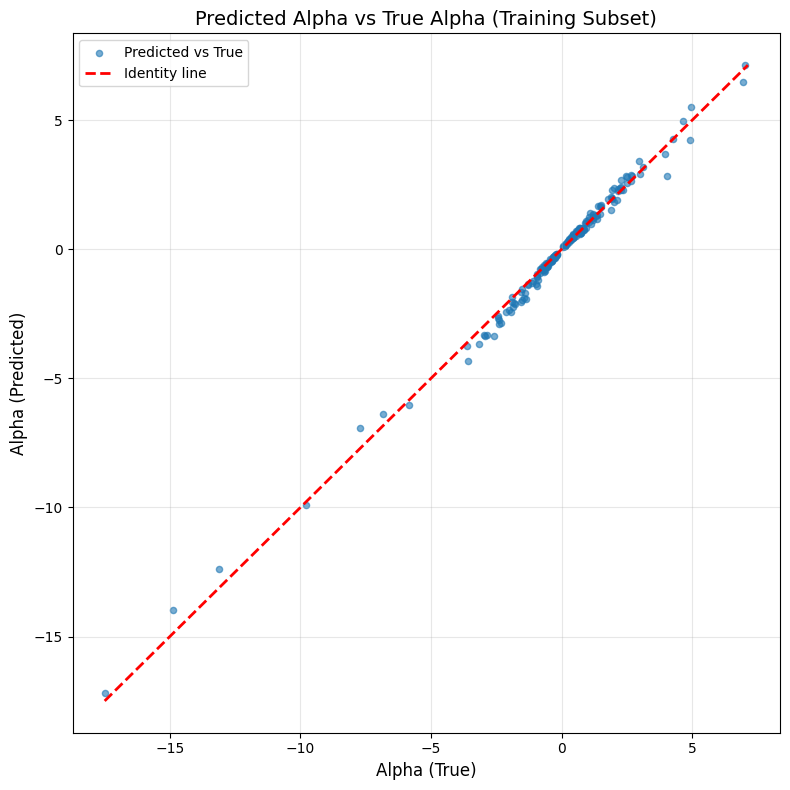


Training subset metrics:
MAE: 0.162601
RMSE: 0.249813
Correlation: 0.995895
Starting training...
Epoch 001 loss=0.454275 time=39.9s
Epoch 002 loss=0.095243 time=24.5s
Epoch 003 loss=0.052278 time=17.1s
Epoch 004 loss=0.034954 time=22.6s
Epoch 005 loss=0.022244 time=24.6s

Generating predictions on test set...
Saved alpha_test_pred50.npy with shape (1000, 1)

Evaluating on training subset...


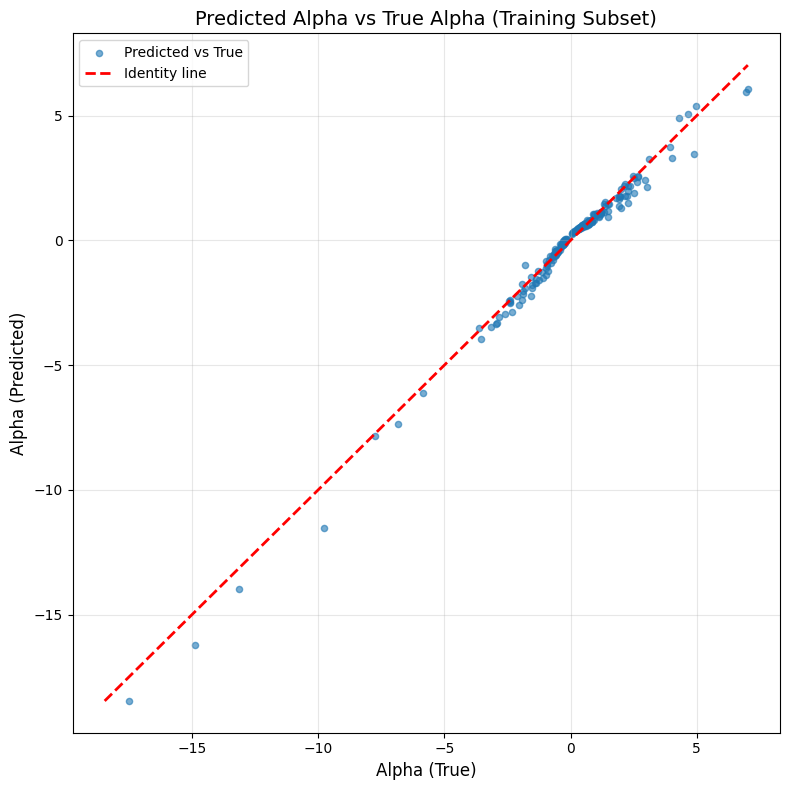


Training subset metrics:
MAE: 0.220122
RMSE: 0.336227
Correlation: 0.993715
Starting training...
Epoch 001 loss=0.530257 time=31.8s
Epoch 002 loss=0.098035 time=15.4s
Epoch 003 loss=0.058718 time=15.0s
Epoch 004 loss=0.046550 time=15.0s
Epoch 005 loss=0.036882 time=15.3s

Generating predictions on test set...
Saved alpha_test_pred25.npy with shape (1000, 1)

Evaluating on training subset...


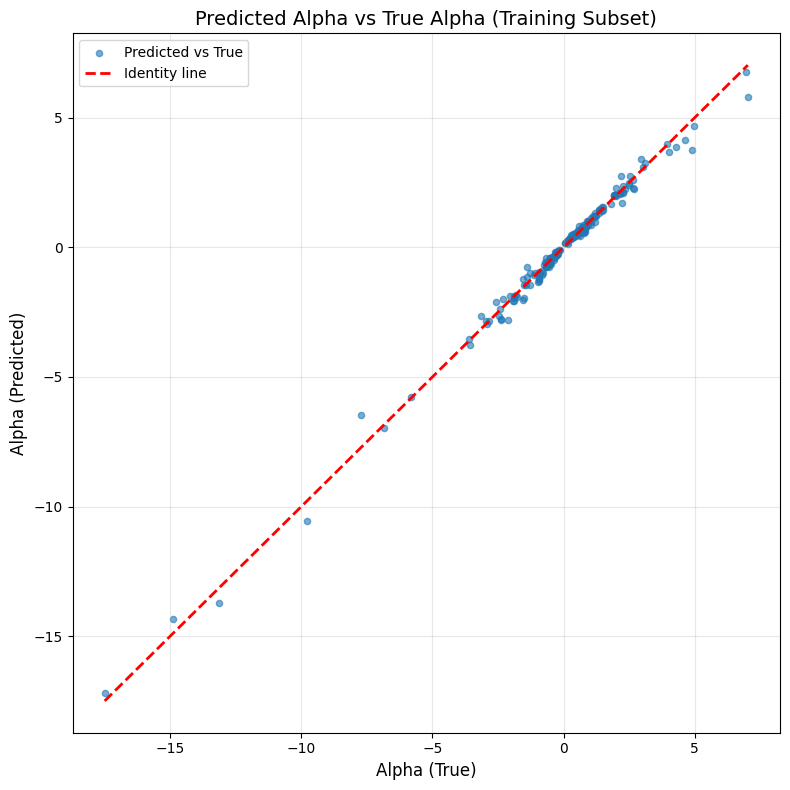


Training subset metrics:
MAE: 0.152361
RMSE: 0.246093
Correlation: 0.996045


In [1]:
# ode_rnn_spiral_fixed.py
import time
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset (adapted for spirals_n.npz format)
# -----------------------------
# Choose which dataset variant to use: 100, 75, 50, or 25
for n in [100, 75, 50, 25]:
    data = np.load(f"spirals_{n}.npz")

    # Expect arrays: data_train (N, n, 3), data_validation (optional), data_test (N, n, 3)
    # channels: t, x, y
    # and alpha_train (N, 1)
    data_train_full = data["data_train"].astype(np.float32)   # (N, T, 3)
    alpha_train = data["alpha_train"].astype(np.float32)      # (N, 1)
    data_test_full = data["data_test"].astype(np.float32)     # (N, T, 3)

    # Extract spatial channels (x,y)
    xy_train = data_train_full[..., 1:3]  # (N, T, 2)
    xy_test  = data_test_full[..., 1:3]   # (N, T, 2)

    N, T, D = xy_train.shape
    assert D == 2

    # Use time channel if present to build t_grid (normalize to [0,1])
    t_sample = data_train_full[0, :, 0].astype(np.float32)
    t_min, t_max = float(t_sample.min()), float(t_sample.max())
    if t_max > t_min:
        t_grid = jnp.array((t_sample - t_min) / (t_max - t_min), dtype=jnp.float32)
    else:
        t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

    # normalize inputs (per-dimension) using training spatial channels
    xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
    xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
    xy_train_n = (xy_train - xy_mean) / xy_std
    xy_test_n  = (xy_test - xy_mean) / xy_std

    alpha_mean = alpha_train.mean(axis=0, keepdims=True)
    alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
    alpha_train_n = (alpha_train - alpha_mean) / alpha_std

    # convert to jax arrays for training
    xy_train_n = jnp.array(xy_train_n)
    alpha_train_n = jnp.array(alpha_train_n)
    xy_test_n = jnp.array(xy_test_n)

    # -----------------------------
    # Model components (Equinox)
    # -----------------------------
    class Encoder(eqx.Module):
        net: eqx.nn.MLP

        def __init__(self, in_size, out_size, *, key):
            self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

        def __call__(self, x0):
            x_mat = jnp.atleast_2d(x0)           # (B, in_size)
            out = jax.vmap(self.net)(x_mat)      # (B, out_size)
            return out

    class ODEFunc(eqx.Module):
        net: eqx.nn.MLP

        def __init__(self, h_dim, *, key):
            self.net = eqx.nn.MLP(in_size=h_dim + 1, out_size=h_dim, width_size=128, depth=2, key=key)

        def __call__(self, t, h, args):
            # Note: this __call__ is not used directly by diffrax; we will call the stored net via vmap in integrate
            h_mat = jnp.atleast_2d(h)
            B = h_mat.shape[0]
            t_feat = jnp.full((B, 1), t, dtype=h_mat.dtype)
            inp = jnp.concatenate([h_mat, t_feat], axis=-1)
            out = jax.vmap(self.net)(inp)
            return out

    class Decoder(eqx.Module):
        net: eqx.nn.MLP

        def __init__(self, in_size, out_size, *, key):
            self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

        def __call__(self, h):
            h_mat = jnp.atleast_2d(h)           # (B, h_dim)
            out = jax.vmap(self.net)(h_mat)     # (B, out_dim)
            return out

    class RNNUpdate(eqx.Module):
        lin_x: eqx.nn.Linear
        lin_h: eqx.nn.Linear
        h_dim: int

        def __init__(self, x_dim, h_dim, key):
            k1, k2 = jax.random.split(key, 2)
            self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
            self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
            self.h_dim = h_dim

        def __call__(self, x, h):
            x_mat = jnp.atleast_2d(x)           # (B, x_dim)
            h_mat = jnp.atleast_2d(h)           # (B, h_dim)
            lin_x_out = jax.vmap(self.lin_x)(x_mat)  # (B, 3*h_dim)
            lin_h_out = jax.vmap(self.lin_h)(h_mat)  # (B, 3*h_dim)
            gates = lin_x_out + lin_h_out
            z, r, o = jnp.split(gates, 3, axis=-1)
            z = jnn.sigmoid(z)
            r = jnn.sigmoid(r)
            o = jnn.tanh(o)
            h_new = (1 - z) * h_mat + z * o
            return h_new                 # (B, h_dim)

    class ODERNN(eqx.Module):
        encoder: Encoder
        odefunc: ODEFunc
        rnn_update: RNNUpdate
        decoder: Decoder
        h_dim: int

        def __init__(self, x_dim, h_dim, *, key=None):
            if key is None:
                key = jax.random.PRNGKey(0)
            k1, k2, k3, k4 = jax.random.split(key, 4)
            self.encoder = Encoder(x_dim, h_dim, key=k1)
            self.odefunc = ODEFunc(h_dim, key=k2)
            self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
            self.decoder = Decoder(h_dim, 1, key=k4)
            self.h_dim = h_dim

    # -----------------------------
    # Solver configuration
    # -----------------------------
    solver = diffrax.Tsit5()
    adjoint = diffrax.BacksolveAdjoint()
    controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)

    # -----------------------------
    # integrate_batch (pass odefunc explicitly via args to avoid closed-over values)
    # -----------------------------
    def integrate_batch(odefunc_module, h0, t0, t1):
        """
        Integrate hidden state from t0 to t1 using the ODE function.
        odefunc_module: ODEFunc Equinox module (passed explicitly)
        h0: (B, h_dim)
        t0, t1: scalars
        returns h1: (B, h_dim)
        """
        h0 = jnp.atleast_2d(h0)
        B, h_dim = h0.shape
        y0 = h0.ravel()

        # rhs that uses the odefunc_module passed in args
        def rhs_flat(t, y, args):
            # args will be (odefunc_module,)
            odefunc_mod = args[0]
            y_mat = y.reshape((B, h_dim))            # (B, h_dim)
            # Build input (B, h_dim+1) and apply the MLP via vmap
            t_feat = jnp.full((B, 1), t, dtype=y_mat.dtype)
            inp = jnp.concatenate([y_mat, t_feat], axis=-1)  # (B, h_dim+1)
            dydt = jax.vmap(odefunc_mod.net)(inp)            # (B, h_dim)
            return dydt.ravel()

        term = diffrax.ODETerm(rhs_flat)

        sol = diffrax.diffeqsolve(
            term,
            solver,
            t0=t0,
            t1=t1,
            y0=y0,
            args=(odefunc_module,),  # pass module explicitly as arg to avoid closed-over value
            dt0=None,
            max_steps=1_000_000,
            adjoint=adjoint,
            stepsize_controller=controller,
            saveat=diffrax.SaveAt(t1=True),
        )

        y_final = sol.ys[0] if hasattr(sol.ys, '__getitem__') else sol.ys
        h1 = y_final.reshape((B, h_dim))
        return h1

    def mse(a, b):
        return jnp.mean((a - b) ** 2)

    # -----------------------------
    # sequence_loss (encoder/decoder/rnn_update called on batches)
    # -----------------------------
    def sequence_loss(model: ODERNN, x_seq, alpha_true, t_grid_static):
        """
        x_seq: (B, T, D)
        alpha_true: (B, 1)
        t_grid_static: (T,)
        """
        B, T_seq, D = x_seq.shape

        # Encode first observation: call encoder on batch input directly -> (B, h_dim)
        h_init = model.encoder(x_seq[:, 0, :])  # (B, h_dim)

        def step_fn(i, h):
            t0 = t_grid_static[i]
            t1 = t_grid_static[i + 1]
            # Pass the odefunc module explicitly to integrate_batch
            h_ode = integrate_batch(model.odefunc, h, t0, t1)  # (B, h_dim)
            h_new = model.rnn_update(x_seq[:, i + 1, :], h_ode)  # (B, h_dim)
            return h_new

        h_final = jax.lax.fori_loop(0, T_seq - 1, step_fn, h_init)

        # Decode to predict alpha: call decoder on batch input directly -> (B, 1)
        alpha_pred = model.decoder(h_final)

        loss = mse(alpha_pred, alpha_true)
        return loss, alpha_pred

    # -----------------------------
    # Training utilities
    # -----------------------------
    def loss_fn(model, x_batch, alpha_batch, t_grid_static):
        loss, _ = sequence_loss(model, x_batch, alpha_batch, t_grid_static)
        params = eqx.filter(model, eqx.is_array)
        leaves = jax.tree_util.tree_leaves(params)
        l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in leaves)
        return loss + l2

    @eqx.filter_jit
    def compute_loss_and_grad(model, x_batch, alpha_batch, t_grid_static):
        loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model, x_batch, alpha_batch, t_grid_static)
        return loss_val, grads

    @eqx.filter_jit
    def apply_updates(model, grads, opt_state, optimizer):
        params = eqx.filter(model, eqx.is_array)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        model = eqx.apply_updates(model, updates)
        return model, opt_state

    def data_loader(xy, alpha, batch_size, shuffle=True):
        """Generate batches of data (xy normalized)."""
        N = xy.shape[0]
        idx = np.arange(N)
        if shuffle:
            np.random.shuffle(idx)
        for i in range(0, N, batch_size):
            b = idx[i:i+batch_size]
            yield xy[b], alpha[b]

    # -----------------------------
    # Initialize model and optimizer
    # -----------------------------
    key = random.PRNGKey(0)
    h_dim = 64
    model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

    learning_rate = 5e-3
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    batch_size = 128
    num_epochs = 5

    # -----------------------------
    # Training loop
    # -----------------------------
    print("Starting training...")
    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        losses = []

        for xb_np, ab_np in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
            xb_j = jnp.array(xb_np)   # (B, T, D)
            ab_j = jnp.array(ab_np)   # (B, 1)

            # Compute loss and gradients
            loss_val, grads = compute_loss_and_grad(model, xb_j, ab_j, t_grid)

            # Apply updates
            model, opt_state = apply_updates(model, grads, opt_state, optimizer)

            losses.append(float(loss_val))

        t1 = time.time()
        print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")

    # -----------------------------
    # Prediction function
    # -----------------------------
    def predict_alpha(model, xy_input, t_grid_static):
        """
        xy_input: (N, T, D) - normalized
        t_grid_static: (T,)
        Returns denormalized predictions (N,1)
        """
        batch_size_pred = 128
        preds = []

        for i in range(0, xy_input.shape[0], batch_size_pred):
            xb = xy_input[i:i+batch_size_pred]  # (B, T, D)
            B = xb.shape[0]
            T_seq = xb.shape[1]

            # Encode first observation -> call encoder on batch
            h = model.encoder(xb[:, 0, :])  # (B, h_dim)

            # Process sequence
            for j in range(T_seq - 1):
                t0 = float(t_grid_static[j])
                t1 = float(t_grid_static[j + 1])
                h = integrate_batch(model.odefunc, h, t0, t1)
                h = model.rnn_update(xb[:, j + 1, :], h)

            # Decode -> call decoder on batch
            alpha_p = model.decoder(h)  # (B, 1)
            preds.append(np.array(alpha_p))

        preds = np.vstack(preds)
        preds_orig = preds * alpha_std + alpha_mean
        return preds_orig

    # -----------------------------
    # Generate predictions and save
    # -----------------------------
    print("\nGenerating predictions on test set...")
    alpha_test_pred = predict_alpha(model, np.array(xy_test_n), t_grid)
    np.save(f"alpha_test_pred{n}.npy", alpha_test_pred)
    print(f"Saved alpha_test_pred{n}.npy with shape {alpha_test_pred.shape}")

    # -----------------------------
    # Evaluate on training subset
    # -----------------------------
    print("\nEvaluating on training subset...")
    subset = 200
    train_pred = predict_alpha(model, np.array(xy_train_n[:subset]), t_grid)
    train_true = np.array(alpha_train[:subset])

    # Plot results
    plt.figure(figsize=(8, 8))
    plt.scatter(train_true.ravel(), train_pred.ravel(), alpha=0.6, s=20, label="Predicted vs True")
    minv = min(train_true.min(), train_pred.min())
    maxv = max(train_true.max(), train_pred.max())
    plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=2, label="Identity line")
    plt.xlabel("Alpha (True)", fontsize=12)
    plt.ylabel("Alpha (Predicted)", fontsize=12)
    plt.legend(fontsize=10)
    plt.title("Predicted Alpha vs True Alpha (Training Subset)", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate and print metrics
    mae = np.mean(np.abs(train_true - train_pred))
    rmse = np.sqrt(np.mean((train_true - train_pred) ** 2))
    corr = np.corrcoef(train_true.ravel(), train_pred.ravel())[0, 1]
    print(f"\nTraining subset metrics:")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"Correlation: {corr:.6f}")


In [1]:
# ode_rnn_spiral_parallel.py
import time
import functools
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Globale Modelldefinitionen (besser außerhalb der Schleife)
# -----------------------------
class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

    def __call__(self, x0):
        x_mat = jnp.atleast_2d(x0)
        out = jax.vmap(self.net)(x_mat)
        return out

class ODEFunc(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, h_dim, *, key):
        self.net = eqx.nn.MLP(in_size=h_dim + 1, out_size=h_dim, width_size=128, depth=2, key=key)

    def __call__(self, t, h, args):
        h_mat = jnp.atleast_2d(h)
        B = h_mat.shape[0]
        t_feat = jnp.full((B, 1), t, dtype=h_mat.dtype)
        inp = jnp.concatenate([h_mat, t_feat], axis=-1)
        out = jax.vmap(self.net)(inp)
        return out

class Decoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

    def __call__(self, h):
        h_mat = jnp.atleast_2d(h)
        out = jax.vmap(self.net)(h_mat)
        return out

class RNNUpdate(eqx.Module):
    lin_x: eqx.nn.Linear
    lin_h: eqx.nn.Linear
    h_dim: int

    def __init__(self, x_dim, h_dim, key):
        k1, k2 = jax.random.split(key, 2)
        self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
        self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
        self.h_dim = h_dim

    def __call__(self, x, h):
        x_mat = jnp.atleast_2d(x)
        h_mat = jnp.atleast_2d(h)
        lin_x_out = jax.vmap(self.lin_x)(x_mat)
        lin_h_out = jax.vmap(self.lin_h)(h_mat)
        gates = lin_x_out + lin_h_out
        z, r, o = jnp.split(gates, 3, axis=-1)
        z = jnn.sigmoid(z)
        r = jnn.sigmoid(r)
        o = jnn.tanh(o)
        h_new = (1 - z) * h_mat + z * o
        return h_new

class ODERNN(eqx.Module):
    encoder: Encoder
    odefunc: ODEFunc
    rnn_update: RNNUpdate
    decoder: Decoder
    h_dim: int

    def __init__(self, x_dim, h_dim, *, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = Encoder(x_dim, h_dim, key=k1)
        self.odefunc = ODEFunc(h_dim, key=k2)
        self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
        self.decoder = Decoder(h_dim, 1, key=k4)
        self.h_dim = h_dim

# -----------------------------
# Solver Konfiguration
# -----------------------------
solver = diffrax.Tsit5()
adjoint = diffrax.BacksolveAdjoint()
controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)

def integrate_batch(odefunc_module, h0, t0, t1):
    h0 = jnp.atleast_2d(h0)
    B, h_dim = h0.shape
    y0 = h0.ravel()

    def rhs_flat(t, y, args):
        odefunc_mod = args[0]
        y_mat = y.reshape((B, h_dim))
        t_feat = jnp.full((B, 1), t, dtype=y_mat.dtype)
        inp = jnp.concatenate([y_mat, t_feat], axis=-1)
        dydt = jax.vmap(odefunc_mod.net)(inp)
        return dydt.ravel()

    term = diffrax.ODETerm(rhs_flat)
    
    # Wichtig: diffrax ist kompatibel mit pmap, solange die Argumente gesharded sind oder broadcasting erlauben.
    sol = diffrax.diffeqsolve(
        term, solver, t0=t0, t1=t1, y0=y0,
        args=(odefunc_module,),
        dt0=None, max_steps=1_000_000, adjoint=adjoint,
        stepsize_controller=controller, saveat=diffrax.SaveAt(t1=True)
    )
    y_final = sol.ys[0] if hasattr(sol.ys, '__getitem__') else sol.ys
    return y_final.reshape((B, h_dim))

def sequence_loss(model: ODERNN, x_seq, alpha_true, t_grid_static):
    B, T_seq, D = x_seq.shape
    h_init = model.encoder(x_seq[:, 0, :])

    def step_fn(i, h):
        t0 = t_grid_static[i]
        t1 = t_grid_static[i + 1]
        h_ode = integrate_batch(model.odefunc, h, t0, t1)
        h_new = model.rnn_update(x_seq[:, i + 1, :], h_ode)
        return h_new

    h_final = jax.lax.fori_loop(0, T_seq - 1, step_fn, h_init)
    alpha_pred = model.decoder(h_final)
    return jnp.mean((alpha_pred - alpha_true) ** 2), alpha_pred

def loss_fn(model, x_batch, alpha_batch, t_grid_static):
    loss, _ = sequence_loss(model, x_batch, alpha_batch, t_grid_static)
    params = eqx.filter(model, eqx.is_array)
    l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params))
    return loss + l2

# Hilfsfunktion zum Teilen der Daten auf Geräte
def shard_batch(x):
    # x shape: (Batch, ...) -> (NumDevices, Batch/NumDevices, ...)
    num_devices = jax.local_device_count()
    batch_size = x.shape[0]
    return x.reshape((num_devices, batch_size // num_devices, *x.shape[1:]))

# -----------------------------
# Hauptskript
# -----------------------------

# Sicherstellen, dass wir 2 Geräte sehen
print(f"Verfügbare Geräte: {jax.local_devices()}")
num_devices = jax.local_device_count()
if num_devices < 2:
    print("WARNUNG: Weniger als 2 GPUs gefunden! Code läuft auf CPU/Single-GPU, pmap hat keinen Speedup.")

for n in [100, 75, 50, 25]:
    print(f"\n--- Processing dataset spirals_{n} ---")
    
    # Laden der Daten (Dummy-Laden simuliert, da Datei nicht vorhanden)
    # Ersetze dies durch deinen echten Load-Code:
    try:
        data = np.load(f"spirals_{n}.npz")
        data_train_full = data["data_train"].astype(np.float32)
        alpha_train = data["alpha_train"].astype(np.float32)
        data_test_full = data["data_test"].astype(np.float32)
    except FileNotFoundError:
        print(f"File spirals_{n}.npz not found, skipping...")
        continue

    # Preprocessing (Wie im Original)
    xy_train = data_train_full[..., 1:3]
    xy_test  = data_test_full[..., 1:3]
    N, T, D = xy_train.shape
    
    t_sample = data_train_full[0, :, 0].astype(np.float32)
    t_min, t_max = float(t_sample.min()), float(t_sample.max())
    if t_max > t_min:
        t_grid = jnp.array((t_sample - t_min) / (t_max - t_min), dtype=jnp.float32)
    else:
        t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

    xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
    xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
    xy_train_n = (xy_train - xy_mean) / xy_std
    xy_test_n  = (xy_test - xy_mean) / xy_std

    alpha_mean = alpha_train.mean(axis=0, keepdims=True)
    alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
    alpha_train_n = (alpha_train - alpha_mean) / alpha_std

    xy_train_n = jnp.array(xy_train_n)
    alpha_train_n = jnp.array(alpha_train_n)
    xy_test_n = jnp.array(xy_test_n)

    # -----------------------------
    # Initialisierung Modell & Optimizer
    # -----------------------------
    key = random.PRNGKey(0)
    h_dim = 64
    model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

    learning_rate = 5e-3
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    # -----------------------------
    # PMAP SETUP (Parallelisierung)
    # -----------------------------
    
    # 1. Schritt: Modell und Optimizer State auf ALLE Geräte replizieren
    model_replicated = jax.device_put_replicated(model, jax.local_devices())
    opt_state_replicated = jax.device_put_replicated(opt_state, jax.local_devices())

    # 2. Schritt: Definiere den Update-Schritt für PMAP
    # Dieser Schritt läuft auf JEDER GPU separat für einen Teil des Batches
    def train_step_single_device(model, opt_state, x, alpha, t_grid_static):
        loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model, x, alpha, t_grid_static)
        # Gradienten mitteln über alle Geräte (AllReduce)
        grads = jax.lax.pmean(grads, axis_name='devices')
        loss_val = jax.lax.pmean(loss_val, axis_name='devices')
        
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_val

    # Pmap Transformation anwenden
    train_step_pmapped = jax.pmap(
        train_step_single_device, 
        axis_name='devices',
        in_axes=(0, 0, 0, 0, None) # model, opt, x, alpha gesharded; t_grid broadcasted
    )

    batch_size = 128
    # Muss durch Anzahl Geräte teilbar sein
    assert batch_size % num_devices == 0, "Batch size must be divisible by number of devices"
    
    num_epochs = 5

    # -----------------------------
    # Training Loop
    # -----------------------------
    print("Starting parallel training...")
    
    def data_loader(xy, alpha, batch_size, shuffle=True):
        N = xy.shape[0]
        idx = np.arange(N)
        if shuffle:
            np.random.shuffle(idx)
        # Drop last un-full batch to ensure shapes work for pmap reshaping
        n_batches = N // batch_size
        for i in range(n_batches):
            b = idx[i*batch_size : (i+1)*batch_size]
            yield xy[b], alpha[b]

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        losses = []

        for xb_np, ab_np in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
            # Daten zu JAX Array
            xb_j = jnp.array(xb_np)
            ab_j = jnp.array(ab_np)
            
            # Daten aufteilen (Sharding): (B, T, D) -> (2, B/2, T, D)
            xb_sharded = shard_batch(xb_j)
            ab_sharded = shard_batch(ab_j)

            # Parallel Step ausführen
            model_replicated, opt_state_replicated, loss_val = train_step_pmapped(
                model_replicated, 
                opt_state_replicated, 
                xb_sharded, 
                ab_sharded, 
                t_grid # t_grid ist klein, wird automatisch gebroadcastet
            )

            # loss_val ist repliziert (z.B. [0.5, 0.5]), wir nehmen den ersten Wert
            losses.append(float(loss_val[0]))

        t1 = time.time()
        print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")

    # -----------------------------
    # Nach dem Training: Modell zusammenführen (Un-replicate)
    # -----------------------------
    # Wir nehmen einfach das Modell von GPU 0, da beide synchronisiert sind
    model_final = jax.tree_util.tree_map(lambda x: x[0], model_replicated)

    # -----------------------------
    # Prediction (Single Device - da Eval meist schnell genug ist)
    # -----------------------------
    def predict_alpha(model, xy_input, t_grid_static):
        batch_size_pred = 128
        preds = []
        # Inference Loop (sequentiell auf GPU 0)
        for i in range(0, xy_input.shape[0], batch_size_pred):
            xb = xy_input[i:i+batch_size_pred]
            B = xb.shape[0]
            T_seq = xb.shape[1]
            h = model.encoder(xb[:, 0, :])
            for j in range(T_seq - 1):
                t0, t1 = float(t_grid_static[j]), float(t_grid_static[j + 1])
                h = integrate_batch(model.odefunc, h, t0, t1)
                h = model.rnn_update(xb[:, j + 1, :], h)
            alpha_p = model.decoder(h)
            preds.append(np.array(alpha_p))
        preds = np.vstack(preds)
        return preds * alpha_std + alpha_mean

    print("\nGenerating predictions on test set...")
    alpha_test_pred = predict_alpha(model_final, np.array(xy_test_n), t_grid)
    np.save(f"alpha_test_pred{n}.npy", alpha_test_pred)
    print(f"Saved alpha_test_pred{n}.npy")

    # Evaluation Plotting (optional)
    print("\nEvaluating on training subset...")
    subset = 200
    train_pred = predict_alpha(model_final, np.array(xy_train_n[:subset]), t_grid)
    train_true = np.array(alpha_train[:subset])

    # Berechnung Metriken
    mae = np.mean(np.abs(train_true - train_pred))
    print(f"MAE: {mae:.6f}")
    
    # Optional: Plotten nur einmal oder am Ende
    # plt.show() wird im Batch-Mode oft weggelassen oder nur gespeichert

Verfügbare Geräte: [CpuDevice(id=0)]
WARNUNG: Weniger als 2 GPUs gefunden! Code läuft auf CPU/Single-GPU, pmap hat keinen Speedup.

--- Processing dataset spirals_100 ---


TypeError: Argument '<jax._src.custom_derivatives.custom_jvp object at 0x000001EC87554F20>' of type '<class 'jax._src.custom_derivatives.custom_jvp'>' is not a valid JAX type

To convert code using `jax.pmap` from a single GPU to multiple GPUs (Data Parallelism), essentially **four exact structural changes** are necessary.


### 1\. State Replication

**Problem:** Each GPU needs its own local copy of the model parameters and the optimizer state to perform calculations.
**Change:** Before the training loop begins, we copy the model and optimizer state to all available devices.

  * **Before:**
    ```python
    model = ...
    opt_state = ...
    ```
  * **After:**
    ```python
    # Copies the object identically to GPU 0, GPU 1, etc.
    model_replicated = jax.device_put_replicated(model, jax.local_devices())
    opt_state_replicated = jax.device_put_replicated(opt_state, jax.local_devices())
    ```

### 2\. Data Sharding

**Problem:** `pmap` expects the input data to have an additional dimension corresponding to the devices. If you have a batch size of 128 and 2 GPUs, you cannot give both the full 128 (that would be double the work); instead, each gets 64.

**Change:** The batch dimension `(B, ...)` must be reshaped to `(Devices, B/Devices, ...)`.

  * **Before:** `x` had shape `(128, T, D)`

  * **After:** `x` is sharded to `(2, 64, T, D)` (for 2 GPUs).

    ```python
    def shard_batch(x):
        num_devices = jax.local_device_count()
        batch_size = x.shape[0]
        # Reshape adds the device dimension
        return x.reshape((num_devices, batch_size // num_devices, *x.shape[1:]))

    # Inside the loop:
    xb_sharded = shard_batch(xb_j)
    ```

### 3\. Gradient Synchronization (`pmean`)

**Problem:** If GPU 1 and GPU 2 calculate separately, they compute different gradients (since they see different data). If they applied these separately, the models on the GPUs would drift apart ("divergence").

**Change:** Inside the training function, the gradients from all devices must be averaged *before* the optimizer applies them. This is the most critical step.

  * **Before:**
    ```python
    loss, grads = eqx.filter_value_and_grad(loss_fn)(...)
    updates, opt_state = optimizer.update(grads, ...)
    ```
  * **After (inside the pmap function):**
    ```python
    loss, grads = eqx.filter_value_and_grad(loss_fn)(...)

    # COMMUNICATION BETWEEN GPUS:
    # Calculates the average of gradients across the 'devices' axis (AllReduce)
    grads = jax.lax.pmean(grads, axis_name='devices')
    loss = jax.lax.pmean(loss, axis_name='devices')

    updates, opt_state = optimizer.update(grads, ...) # Now all GPUs use the exact same update
    ```

### 4\. The `pmap` Wrapper instead of `jit`

**Problem:** `jit` compiles code for a single device. We need a function that executes code in parallel.

**Change:** We replace `@eqx.filter_jit` with `jax.pmap`.

  * **Before:**
    ```python
    @eqx.filter_jit
    def make_step(model, opt_state, ...):
        ...
    ```
  * **After:**
    ```python
    # Define function (without decorator)
    def make_step_single(model, opt_state, ...):
        ... (Code including pmean) ...

    # Explicitly wrap with pmap
    make_step_pmapped = jax.pmap(
        make_step_single,
        axis_name='devices',       # Name for pmean reference
        in_axes=(0, 0, 0, 0, None) # 0 = sharded (Model, Opt, X, Alpha), None = broadcast (t_grid)
    )
    ```
    *Explanation of `in_axes`:* `0` means the argument has a device dimension (created in Step 2). `None` means the argument is the same for all GPUs (e.g., the time grid `t_grid`, which is small and can simply be broadcasted/copied).

### 5\. Un-Replication (Merging)

**Problem:** After training, you have `model_replicated`, which is technically a list of 2 identical models (one on GPU 0, one on GPU 1). For saving or inference, you only need one.

**Change:** Simply extract the first element.

  * **After:**
    ```python
    # Just take the model from device 0
    model_final = jax.tree_util.tree_map(lambda x: x[0], model_replicated)
    ```

### Summary

The workflow changes from:

1.  `Init` -\> `Train Loop (JIT)` -\> `Save`

To:

1.  `Init` -\> **`Replicate`** -\> `Train Loop (PMAP + **Shard** + **Pmean**)` -\> **`Un-Replicate`** -\> `Save`

In [ ]:
### 1\. Replikation des Zustands (Replication)

#**Problem:** Jede GPU benötigt ihre eigene Kopie der Modellparameter und des Optimizer-Status, um lokal rechnen zu können.
#**Änderung:** Bevor die Trainingsschleife beginnt, kopieren wir das Modell und den Optimizer-Status auf alle verfügbaren Geräte.

#  * **Vorher:**
     model = ...
    opt_state = ...
 # * **Nachher:**
 
    # Kopiert das Objekt identisch auf GPU 0, GPU 1, etc.
    model_replicated = jax.device_put_replicated(model, jax.local_devices())
    opt_state_replicated = jax.device_put_replicated(opt_state, jax.local_devices())


### 2\. Daten-Aufteilung (Sharding)

#**Problem:** `pmap` erwartet, dass die Eingabedaten eine zusätzliche Dimension für die Geräte haben. Wenn du eine Batch-Size von 128 hast und 2 GPUs, darfst du nicht beiden 128 geben (das wäre doppelte Arbeit), sondern jede bekommt 64.
#**Änderung:** Die Batch-Dimension `(B, ...)` muss umgeformt werden zu `(Devices, B/Devices, ...)`.

#**Vorher:** `x` hatte Shape `(128, T, D)`

#**Nachher:** `x` wird gesharded zu `(2, 64, T, D)` (bei 2 GPUs).
    def shard_batch(x):
        num_devices = jax.local_device_count()
        batch_size = x.shape[0]
        # Reshape fügt die Geräte-Dimension hinzu
        return x.reshape((num_devices, batch_size // num_devices, *x.shape[1:]))

    # In der Schleife:
    xb_sharded = shard_batch(xb_j)
### 3\. Gradienten-Synchronisation (`pmean`)

**Problem:** Wenn GPU 1 und GPU 2 getrennt rechnen, erhalten sie unterschiedliche Gradienten (da sie unterschiedliche Daten sehen). Würden sie diese separat anwenden, würden die Modelle auf den GPUs auseinanderdriften ("Divergenz").
**Änderung:** Innerhalb der Trainingsfunktion müssen die Gradienten aller Geräte gemittelt werden, *bevor* der Optimizer sie anwendet. Das ist der wichtigste Schritt.

  * **Vorher:**
    ```python
    loss, grads = eqx.filter_value_and_grad(loss_fn)(...)
    updates, opt_state = optimizer.update(grads, ...)
    ```
  * **Nachher (innerhalb der pmap-Funktion):**
    ```python
    loss, grads = eqx.filter_value_and_grad(loss_fn)(...)

    # KOMMUNIKATION ZWISCHEN GPUS:
    # Berechnet den Durchschnitt der Gradients über die Achse 'devices'
    grads = jax.lax.pmean(grads, axis_name='devices')
    loss = jax.lax.pmean(loss, axis_name='devices')

    updates, opt_state = optimizer.update(grads, ...) # Jetzt nutzen alle GPUs denselben Update
    ```

### 4\. Der `pmap`-Wrapper statt `jit`

**Problem:** `jit` kompiliert Code für ein Gerät. Wir brauchen eine Funktion, die Code parallel ausführt.
**Änderung:** Wir ersetzen `@eqx.filter_jit` durch `jax.pmap`.

  * **Vorher:**
    ```python
    @eqx.filter_jit
    def make_step(model, opt_state, ...):
        ...
    ```
  * **Nachher:**
    ```python
    # Definition der Funktion (ohne Dekorator)
    def make_step_single(model, opt_state, ...):
        ... (Code mit pmean) ...

    # Explizites Wrappen mit pmap
    make_step_pmapped = jax.pmap(
        make_step_single,
        axis_name='devices',       # Name für pmean Referenz
        in_axes=(0, 0, 0, 0, None) # 0 = gesharded (Model, Opt, X, Alpha), None = broadcast (t_grid)
    )
    ```
    *Erklärung `in_axes`:* `0` bedeutet, das Argument hat eine Geräte-Dimension (die wir in Schritt 2 erstellt haben). `None` bedeutet, das Argument ist für alle GPUs gleich (z.B. das Zeit-Gitter `t_grid`, das klein ist und kopiert werden kann).

### 5\. Zusammenführung (Un-Replication)

**Problem:** Nach dem Training hast du ein `model_replicated`, das eigentlich eine Liste von 2 identischen Modellen ist (eines auf GPU 0, eines auf GPU 1). Zum Speichern oder für die Inference brauchst du nur eines.
**Änderung:** Einfaches Extrahieren des ersten Elements.

  * **Nachher:**
    ```python
    # Nimm einfach das Modell von Gerät 0
    model_final = jax.tree_util.tree_map(lambda x: x[0], model_replicated)
    ```

### Zusammenfassung

Der Ablauf ändert sich von:

1.  `Init` -\> `Train Loop (JIT)` -\> `Save`

Zu:

1.  `Init` -\> **`Replicate`** -\> `Train Loop (PMAP + **Shard** + **Pmean**)` -\> **`Un-Replicate`** -\> `Save`